In [1]:
import sys
sys.path.append('../')

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyproj
from global_land_mask import globe

In [3]:
lon_center = 2
lat_center = 62
source_crs = ccrs.PlateCarree()
target_crs = ccrs.LambertAzimuthalEqualArea(lon_center, lat_center)
globe = ccrs.Orthographic(lon_center, lat_center)
t = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
x_center, y_center = 0, 0#t.transform(lon_center, lat_center)

In [4]:
grid_nx = 40
grid_ny = 60
cell_size = 20000
grid_x_size = grid_nx * cell_size
grid_y_size = grid_ny * cell_size
xmin, xmax = x_center - grid_x_size/2, x_center + grid_x_size/2
ymin, ymax = y_center - grid_y_size/2, y_center + grid_y_size/2
x_points = np.linspace(xmin, xmax, grid_nx)
y_points = np.linspace(ymin, ymax, grid_ny)
grid_x, grid_y = np.meshgrid(x_points, y_points)

In [5]:
lon_min, _ = t.transform(x_center - grid_x_size/2, y_center, direction='INVERSE')
_, lat_min = t.transform(x_center, y_center - grid_y_size/2, direction='INVERSE')
lon_max, _ = t.transform(x_center + grid_x_size/2, y_center, direction='INVERSE')
_, lat_max = t.transform(x_center, y_center + grid_y_size/2, direction='INVERSE')

lon_points = np.linspace(lon_min, lon_max, grid_nx)
lat_points = np.linspace(lat_min, lat_max, grid_ny)
grid_lon, grid_lat = np.meshgrid(lon_points, lat_points)
print(lon_min, lat_min, lon_max, lat_max)

-5.6002499368126415 56.61225606523047 9.600249936812626 67.38398900084628


In [12]:
def plot_grid_bounds(xmin, xmax, ymin, ymax, t, c='cyan'):
    plt.plot(xmin, ymin, '.', color=c)
    plt.text(xmin, ymin, '{:.1f},{:.1f}'.format(*t.transform(xmin, ymin, direction='INVERSE')), ha='right', va='top')
    plt.plot(xmax, ymin, '.', color=c)
    plt.text(xmax, ymin, '{:.1f},{:.1f}'.format(*t.transform(xmax, ymin, direction='INVERSE')), ha='left', va='top')
    plt.plot(xmax, ymax, '.', color=c)
    plt.text(xmax, ymax, '{:.1f},{:.1f}'.format(*t.transform(xmax, ymax, direction='INVERSE')), ha='left', va='bottom')
    plt.plot(xmin, ymax, '.', color=c)
    plt.text(xmin, ymax, '{:.1f},{:.1f}'.format(*t.transform(xmin, ymax, direction='INVERSE')), ha='right', va='bottom')

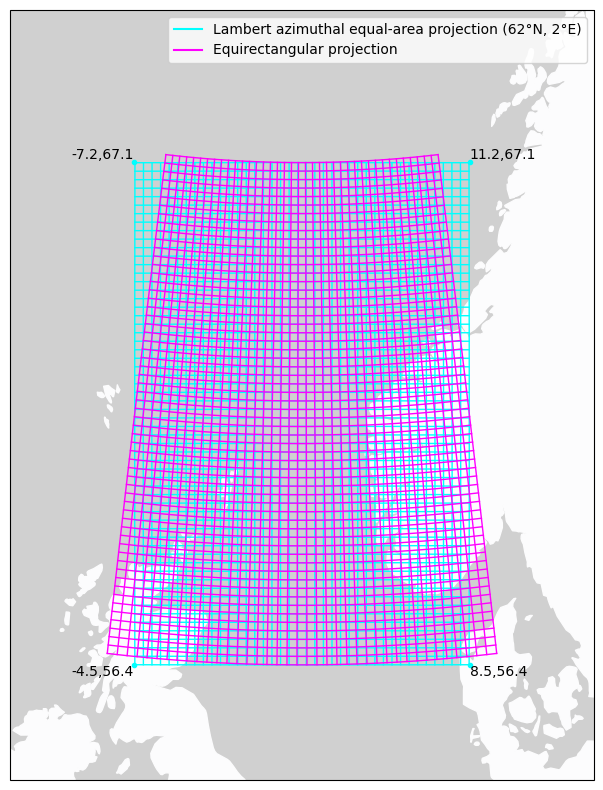

In [13]:
import cartopy.feature as cfeature
from matplotlib.lines import Line2D 

fig = plt.figure(figsize=(8,10))
ax = plt.axes(projection=globe)
# ax.stock_img()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='#d0d0d0'))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='#fcfcfd'))
# ax.coastlines()
for row_x, row_y in zip(grid_x, grid_y): 
    ax.plot(row_x, row_y, c='cyan', lw=1., transform=target_crs)
for col_x, col_y in zip(grid_x.T, grid_y.T): 
    ax.plot(col_x, col_y, c='cyan', lw=1., transform=target_crs)

plot_grid_bounds(xmin, xmax, ymin, ymax, t)

for row_lon, row_lat in zip(grid_lon, grid_lat): 
    ax.plot(row_lon, row_lat, c='magenta', lw=1., transform=source_crs)
for col_lon, col_lat in zip(grid_lon.T, grid_lat.T): 
    ax.plot(col_lon, col_lat, c='magenta', lw=1., transform=source_crs)

pad = 3
ax.set_extent([lon_min-pad, lon_max+pad, lat_min-pad, lat_max+pad], crs=source_crs)
# ax.set_extent([-6, 10, 55, 60], crs=source_crs)
xy_legend = Line2D([], [], color='cyan', label=f'Lambert azimuthal equal-area projection ({lat_center}°N, {lon_center}°E)')
latlon_legend = Line2D([], [], color='magenta', label='Equirectangular projection')

plt.legend(handles=[xy_legend, latlon_legend])
plt.show()

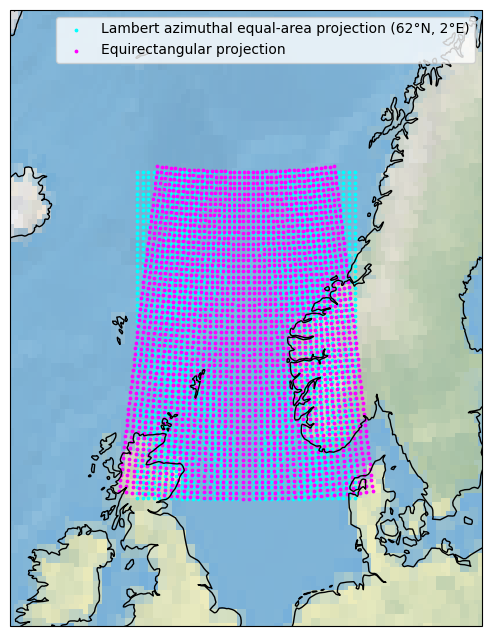

In [14]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=globe)
ax.stock_img()
ax.coastlines()
marker_size = 3.
ax.scatter(grid_x, grid_y, c='cyan', s=marker_size, transform=target_crs, label=f'Lambert azimuthal equal-area projection ({lat_center}°N, {lon_center}°E)')
ax.scatter(grid_lon, grid_lat, c='magenta', s=marker_size, transform=source_crs, label='Equirectangular projection')
pad = 5
# ax.set_extent([-20, 20, 50, 80], crs=source_crs)
ax.set_extent([lon_min-pad, lon_max+pad, lat_min-pad, lat_max+pad], crs=source_crs)
plt.legend()
plt.show()

In [15]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    x = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(x))
    r = 6372.8
    return c * r

def grid_distortion(lon_grid, lat_grid, relative=False):
    lon1, lat1 = lon_grid[:-1,:-1].flatten(), lat_grid[:-1,:-1].flatten()
    lon2, lat2 = lon_grid[1:,:-1].flatten(), lat_grid[1:,:-1].flatten()
    distancesNS = haversine(lon1, lat1, lon2, lat2)
    
    lon1, lat1 = lon_grid[:-1,:-1].flatten(), lat_grid[:-1,:-1].flatten()
    lon2, lat2 = lon_grid[:-1,1:].flatten(), lat_grid[:-1,1:].flatten()
    distancesEW = haversine(lon1, lat1, lon2, lat2)
    
    if relative:
        mNS = np.mean(distancesNS)
        mEW = np.mean(distancesEW)
        return (distancesNS - mNS) / mNS, (distancesEW - mEW) / mEW
    else:
        return distancesNS, distancesEW

In [16]:
xy_distNS, xy_distEW = grid_distortion(*t.transform(grid_x, grid_y, direction='INVERSE'), relative=True)
latlon_distNS, latlon_distEW = grid_distortion(grid_lon, grid_lat, relative=True)
xy_dist = 0.5 * (xy_distNS + xy_distEW)
latlon_dist = 0.5 * (latlon_distNS + latlon_distEW)

In [17]:
print(f"xy grid     - NS: {np.std(xy_distNS):.6f} | EW: {np.std(xy_distEW):.6f} | NSEW: {np.std(xy_dist):.6f} | maxdist: {xy_dist.max() / xy_dist.min():.6f}")
print(f"latlon grid - NS: {np.std(latlon_distNS):.6f} | EW: {np.std(latlon_distEW):.6f} | NSEW: {np.std(latlon_dist):.6f} | maxdist: {latlon_dist.max() / latlon_dist.min():.6f}")

xy grid     - NS: 0.000548 | EW: 0.000401 | NSEW: 0.000291 | maxdist: -1.122878
latlon grid - NS: 0.000000 | EW: 0.101725 | NSEW: 0.050862 | maxdist: -0.968179


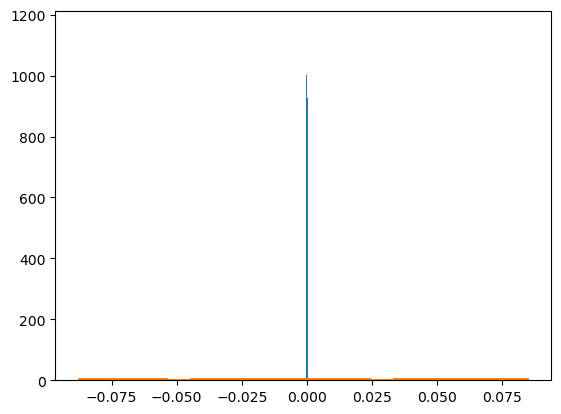

In [18]:
plt.hist(xy_dist, bins=20, density=True)
plt.hist(latlon_dist, bins=20, density=True)
plt.show()

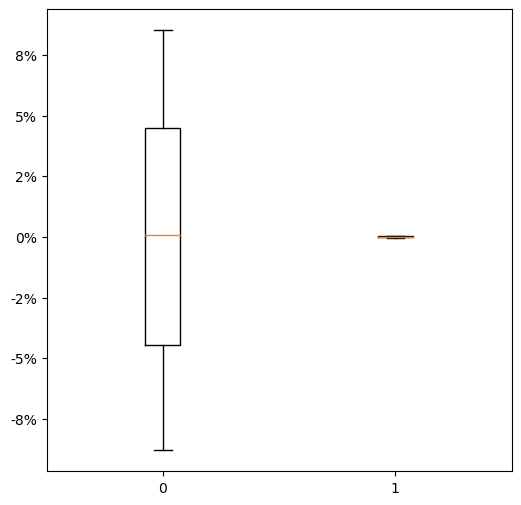

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
plt.boxplot(latlon_dist, positions=[0])
plt.boxplot(xy_dist, positions=[1])
ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
plt.show()

In [20]:
latlon_dist.min(), latlon_dist.max()

(-0.08796097362059946, 0.0851619361087291)

In [21]:
latlon_distNS, latlon_distEW = grid_distortion(grid_lon, grid_lat, relative=False)
latlon_area = latlon_distNS * latlon_distEW
latlon_area.max() / latlon_area.min()

1.4201614377418637

In [22]:
xy_distNS, xy_distEW = grid_distortion(*t.transform(grid_x, grid_y, direction='INVERSE'), relative=False)
xy_area = xy_distNS * xy_distEW
f"{xy_area.max() / xy_area.min():%}"

'100.204823%'

In [23]:
xy_distNS

array([20.32582283, 20.32679345, 20.32771293, ..., 20.30083123,
       20.29996645, 20.29905076])

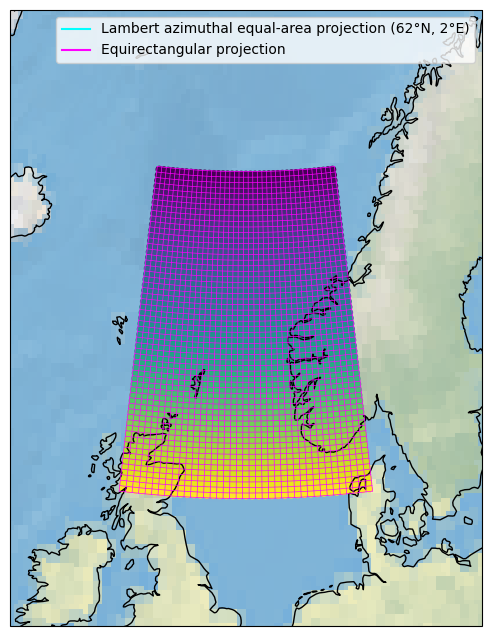

In [24]:
from matplotlib.lines import Line2D 

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=globe)
ax.stock_img()
ax.coastlines()
# for row_x, row_y in zip(grid_x, grid_y): 
#     ax.plot(row_x, row_y, c='cyan', lw=1., transform=target_crs, label=f'Lambert azimuthal equal-area projection ({lat_center}°N, {lon_center}°E)')
# for col_x, col_y in zip(grid_x.T, grid_y.T): 
#     ax.plot(col_x, col_y, c='cyan', lw=1., transform=target_crs)

for row_lon, row_lat in zip(grid_lon, grid_lat): 
    ax.plot(row_lon, row_lat, c='magenta', lw=.5, transform=source_crs)
for col_lon, col_lat in zip(grid_lon.T, grid_lat.T): 
    ax.plot(col_lon, col_lat, c='magenta', lw=.5, transform=source_crs)
ax.scatter(0.5*(grid_lon[1:,1:] + grid_lon[:-1,:-1]), 0.5*(grid_lat[1:,1:] + grid_lat[:-1,:-1]), c=latlon_area, s=20, transform=source_crs)

pad = 5
ax.set_extent([lon_min-pad, lon_max+pad, lat_min-pad, lat_max+pad], crs=source_crs)
xy_legend = Line2D([], [], color='cyan', label=f'Lambert azimuthal equal-area projection ({lat_center}°N, {lon_center}°E)')
latlon_legend = Line2D([], [], color='magenta', label='Equirectangular projection')

plt.legend(handles=[xy_legend, latlon_legend])
plt.show()

## Distance distortion for uniformly sampled lines

In [25]:
n_samples = 1000
x_samples = np.random.uniform(xmin, xmax, (n_samples, 2))
y_samples = np.random.uniform(ymin, ymax, (n_samples, 2))

lon_samples = np.random.uniform(lon_min, lon_max, (n_samples, 2))
lat_samples = np.random.uniform(lat_min, lat_max, (n_samples, 2))

In [266]:
x0, x1 = x_samples[:,0], x_samples[:,1]
y0, y1 = y_samples[:,0], y_samples[:,1]
proj_dist = np.sqrt((x0 - x1)**2 + (y0 - y1)**2)
true_xy_dist = haversine(*t.transform(x0, y0, direction='INVERSE'), *t.transform(x1, y1, direction='INVERSE'))
proj_ratio = true_xy_dist / proj_dist

In [267]:
lon0, lon1 = lon_samples[:,0], lon_samples[:,1]
lat0, lat1 = lat_samples[:,0], lat_samples[:,1]
lonlat_dist = np.sqrt((lon0 - lon1)**2 + (lat0 - lat1)**2)
true_lonlat_dist = haversine(lon0, lat0, lon1, lat1)
lonlat_ratio = true_lonlat_dist / lonlat_dist

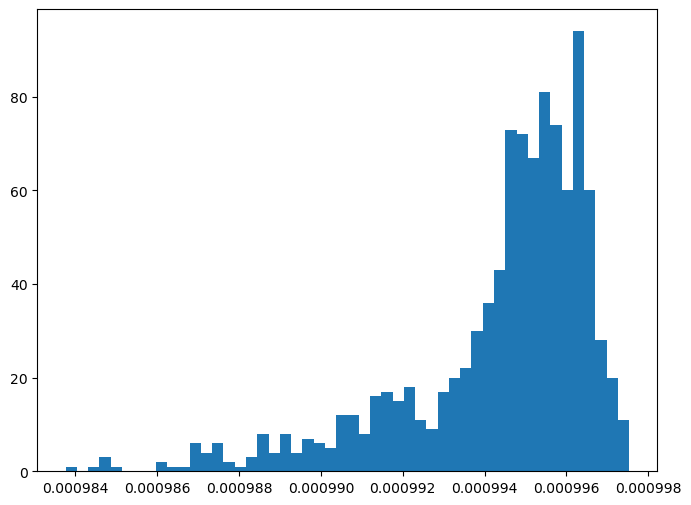

In [268]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(proj_ratio, bins=50)
plt.show()

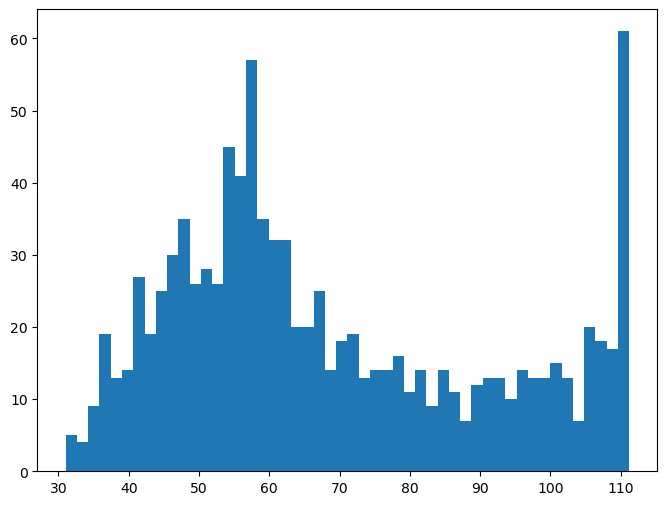

In [269]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(lonlat_ratio, bins=50)
plt.show()